In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd

In [2]:
path_cats_and_dogs = f"{getcwd()}/../tmp2/cats-and-dogs.zip"
shutil.rmtree('/tmp')

local_zip = path_cats_and_dogs
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

1500
1500


In [4]:
try:
    os.mkdir(os.path.join('/', 'tmp', 'cats-v-dogs'))
    os.mkdir(os.path.join('/', 'tmp', 'cats-v-dogs', 'training'))
    os.mkdir(os.path.join('/', 'tmp', 'cats-v-dogs', 'testing'))
    os.mkdir(os.path.join('/', 'tmp', 'cats-v-dogs', 'training', 'cats'))
    os.mkdir(os.path.join('/', 'tmp', 'cats-v-dogs', 'training', 'dogs'))
    os.mkdir(os.path.join('/', 'tmp', 'cats-v-dogs', 'testing', 'cats'))
    os.mkdir(os.path.join('/', 'tmp', 'cats-v-dogs', 'testing', 'dogs'))
except OSError:
    pass

In [9]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    fnames = os.listdir(SOURCE)
    fnames = random.sample(fnames, len(fnames))
    train = fnames[:int(len(fnames) * SPLIT_SIZE)]
    test = fnames[int(len(fnames) * SPLIT_SIZE):]
    
    if len(train) > 0:
        for fname in train:
            path_org = os.path.join(SOURCE, fname)
            path_copied = os.path.join(TRAINING, fname)
            copyfile(path_org, path_copied)
    if len(test) > 0:
        for fname in test:
            path_org = os.path.join(SOURCE, fname)
            path_copied = os.path.join(TESTING, fname)
            copyfile(path_org, path_copied)

CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [10]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

1350
1350
150
150


In [12]:
# DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [15]:
TRAINING_DIR = '/tmp/cats-v-dogs/training'   
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')  

# NOTE: YOU MUST USE A BATCH SIZE OF 10 (batch_size=10) FOR THE 
# TRAIN GENERATOR.
train_generator = train_datagen.flow_from_directory(
                    TRAINING_DIR,
                    target_size=(150, 150),
                    batch_size=10,
                    class_mode='binary')

VALIDATION_DIR = '/tmp/cats-v-dogs/testing/' 
validation_datagen = ImageDataGenerator(rescale=1./255)   

# NOTE: YOU MUST USE A BACTH SIZE OF 10 (batch_size=10) FOR THE 
# VALIDATION GENERATOR.
validation_generator = validation_datagen.flow_from_directory(
                        VALIDATION_DIR,
                        target_size=(150, 150),
                        batch_size=10,
                        class_mode='binary')  

Found 2700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [16]:
history = model.fit_generator(train_generator,
                              epochs=2,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/2
270/270 [==============================] - 60s 223ms/step - loss: 0.7199 - acc: 0.4896 - val_loss: 0.6926 - val_acc: 0.5433
Epoch 2/2
270/270 [==============================] - 54s 200ms/step - loss: 0.6954 - acc: 0.5344 - val_loss: 0.6844 - val_acc: 0.5333


Text(0.5, 1.0, 'Training and validation loss')

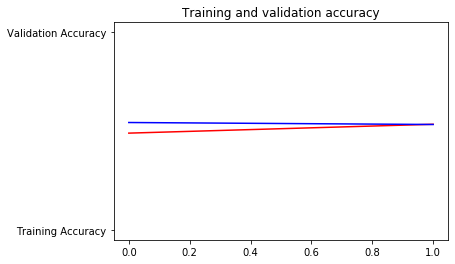

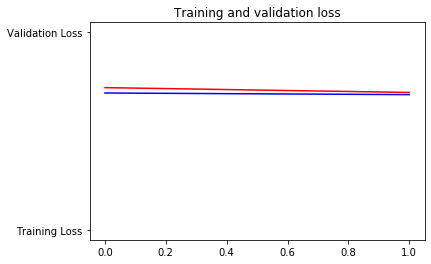

In [17]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')